In [227]:
#!pip install seaborn

## 모델 의 False_alarm 확인 !

config.yaml 파일과 모델 있는지 확인

In [228]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from omegaconf import OmegaConf
import pandas as pd
import numpy as np
import pickle as pickle
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot


In [229]:
#yaml 파일 이름 입력!
conf = OmegaConf.load(f"../config/exp2.yaml")

#모델 로드
model_name = conf.model.model_name
load_model = conf.path.load_model

In [230]:
# 모델 정보 load
batch_size = conf.train.per_device_train_batch_size
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(load_model)
model.to(device)
print('--load model --- ')

--load model --- 


In [231]:
#RE-Dataset 로드
class RE_Dataset(torch.utils.data.Dataset):
    """Dataset 구성을 위한 class."""

    def __init__(self, pair_dataset: pd.DataFrame, labels: np.ndarray):
        self.pair_dataset = pair_dataset
        self.labels = labels

    def __getitem__(self, idx: int) -> torch.Tensor:
        item = {
            key: val[idx].clone().detach() for key, val in self.pair_dataset.items()
        }
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self) -> int:
        return len(self.labels)

In [232]:
# 기타 함수들 로드
def label_to_num(label: np.ndarray) -> list:
    num_label = []
    with open("/opt/ml/code/dict_label_to_num.pkl", "rb") as f:
        dict_label_to_num = pickle.load(f)
    for v in label:
        num_label.append(dict_label_to_num[v])

    return num_label

def num_to_label(label: np.ndarray) -> list:
    """
    숫자로 되어 있던 class를 원본 문자열 라벨로 변환 합니다.
    """
    origin_label = []
    with open("/opt/ml/code/dict_num_to_label.pkl", "rb") as f:
        dict_num_to_label = pickle.load(f)
    for v in label:
        origin_label.append(dict_num_to_label[v])

    return origin_label

In [233]:
# 기타 함수들 로드
def preprocessing_dataset(dataset: pd.DataFrame) -> pd.DataFrame:
    """처음 불러온 csv 파일을 원하는 형태의 DataFrame으로 변경 시켜줍니다."""
    subject_entity = []
    object_entity = []
    for i, j in zip(dataset["subject_entity"], dataset["object_entity"]):
        i = i[1:-1].split(",")[0].split(":")[1]
        j = j[1:-1].split(",")[0].split(":")[1]

        subject_entity.append(i)
        object_entity.append(j)
    out_dataset = pd.DataFrame(
        {
            "id": dataset["id"],
            "sentence": dataset["sentence"],
            "subject_entity": subject_entity,
            "object_entity": object_entity,
            "label": dataset["label"],
        }
    )
    return out_dataset
    
def load_data(dataset_dir: str) -> pd.DataFrame:
    """csv 파일을 경로에 맞게 불러 옵니다."""
    pd_dataset = pd.read_csv(dataset_dir)
    dataset = preprocessing_dataset(pd_dataset)

    return dataset


def tokenized_dataset(dataset: pd.DataFrame, tokenizer: AutoTokenizer) -> torch.Tensor:
    """tokenizer에 따라 sentence를 tokenizing 합니다."""
    concat_entity = []
    for e01, e02 in zip(dataset["subject_entity"], dataset["object_entity"]):
        temp = ""
        temp = e01 + "[SEP]" + e02
        concat_entity.append(temp)
    tokenized_sentences = tokenizer(
        concat_entity,
        list(dataset["sentence"]),
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256,
        add_special_tokens=True,
    )
    return tokenized_sentences

def get_dataset(data_path: str, tokenizer: AutoTokenizer) -> RE_Dataset:
    """데이터셋을 Trainer에 넣을 수 있도록 처리하여 리턴합니다.

    Args:
        data_path (str): 가져올 데이터의 주소입니다.
        tokenizer (AutoTokenizer): 데이터를 토큰화할 토크나이저입니다.

    Returns:
        pd.DataFrame: _description_
    """
    dataset = load_data(data_path)
    dataset_label = label_to_num(dataset["label"].values)
    # tokenizing dataset
    dataset_tokens = tokenized_dataset(dataset, tokenizer)
    # make dataset for pytorch.
    dataset = RE_Dataset(dataset_tokens, dataset_label)
    return dataset

In [234]:
#토큰화된 데이터셋 준비
valid_dataset = get_dataset('/opt/ml/level2_klue_nlp-level2-nlp-11/dataset/train/new_valid.csv',tokenizer)

In [235]:
#inference 함수 로드
def inference(model, tokenized_sent, batch_size, device):
    """
    test dataset을 DataLoader로 만들어 준 후,
    batch_size로 나눠 model이 예측 합니다.
    """
    dataloader = DataLoader(tokenized_sent, batch_size, shuffle=False)
    model.eval()

    output_pred = []
    output_prob = []
    for i, data in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            outputs = model(
                input_ids=data["input_ids"].to(device),
                attention_mask=data["attention_mask"].to(device),
                token_type_ids=data["token_type_ids"].to(device),
            )
        logits = outputs[0]
        prob = F.softmax(logits, dim=-1).detach().cpu().numpy()
        logits = logits.detach().cpu().numpy()
        result = np.argmax(logits, axis=-1)

        output_pred.append(result)
        output_prob.append(prob)

    return (
        np.concatenate(output_pred).tolist(),
        np.concatenate(output_prob, axis=0).tolist(),
    )

In [236]:
#infernce 저장
pred_answer, output_prob = inference(
    model, valid_dataset, batch_size , device)  # model에서 class 추론
pred_answer = num_to_label(pred_answer)  # 숫자로 된 class를 원래 문자열 라벨로 변환.

100%|██████████| 203/203 [01:24<00:00,  2.42it/s]


In [237]:
print(pred_answer[:5])

['org:top_members/employees', 'org:top_members/employees', 'no_relation', 'org:top_members/employees', 'org:top_members/employees']


In [238]:
#valid 데이터 로드
valid_df = pd.read_csv('/opt/ml/level2_klue_nlp-level2-nlp-11/dataset/train/new_valid.csv')
valid_df = preprocessing_dataset(valid_df)

In [239]:
valid_df['pred_answer'] = pred_answer

In [240]:
valid_df.head()

,id,sentence,subject_entity,object_entity,label,pred_answer
0,29197,"이날 행사는 권오봉 여수시장, 김형국 GS칼텍스 사장 등이 참석했다.",'GS칼텍스','김형국',org:top_members/employees,org:top_members/employees
1,2998,광주광역시(시장 이용섭)가 올해 135억원을 투입해 선순환 사회적경제 일자리 800...,'광주광역시','이용섭',org:top_members/employees,org:top_members/employees
2,8036,"조선공산당, 조선인민당, 남조선신민당, 조선민족혁명당 등과 전평, 전농, 청년총동맹...",'조선민족혁명당','김원봉',no_relation,no_relation
3,29434,"이날 캠페인에는 하이트진로 김인규 대표, 변수남 부산소방본부장을 비롯해 부산진소방서...",'하이트진로','김인규',org:top_members/employees,org:top_members/employees
4,5082,홍정규 미래통합당은 23일 서울 종로에 황교안 대표를 단수후보로 추천했다.,'미래통합당','황교안',org:top_members/employees,org:top_members/employees


In [241]:
#valid_label, valid_predict 리스트 추출
valid_label = valid_df['label'].tolist()
valid_predict = valid_df['pred_answer'].tolist()

In [242]:
#valid_dict 정답 과 오답 count [True, False]
valid_dict = { i : [0,0] for i in list(set(valid_df['label'])) }
for x in zip(valid_label , valid_predict) :
    if x[0] == x[1] :
        valid_dict[x[0]][0] = valid_dict[x[0]][0] + 1
    else :
        valid_dict[x[0]][1] = valid_dict[x[0]][1] + 1



In [243]:
#데이터 총 개수별 sorted
valid_item = sorted(valid_dict.items(), key = lambda x : sum(x[1]), reverse= True)

In [244]:
#총 데이터 개수로 정렬, 오탐률 계산 및 저장
valid_percent = {}
for x , y in valid_item :
    print(f'{x:30} : {y[1] / sum(y) : 0.5f} , [True,False] : {valid_dict[x]} ')
    valid_percent[x] = y[1] / sum(y)

no_relation                    :  0.24764 , [True,False] : [1434, 472] 
org:top_members/employees      :  0.02921 , [True,False] : [831, 25] 
per:employee_of                :  0.12465 , [True,False] : [625, 89] 
per:title                      :  0.05952 , [True,False] : [395, 25] 
org:member_of                  :  0.19571 , [True,False] : [300, 73] 
org:alternate_names            :  0.09091 , [True,False] : [240, 24] 
per:origin                     :  0.19106 , [True,False] : [199, 47] 
org:place_of_headquarters      :  0.18410 , [True,False] : [195, 44] 
per:date_of_birth              :  0.00885 , [True,False] : [224, 2] 
per:alternate_names            :  0.06500 , [True,False] : [187, 13] 
per:spouse                     :  0.02516 , [True,False] : [155, 4] 
per:colleagues                 :  0.25472 , [True,False] : [79, 27] 
per:parents                    :  0.08654 , [True,False] : [95, 9] 
org:founded                    :  0.08889 , [True,False] : [82, 8] 
org:members              

per:place_of_residence              :  0.92105 , label_data_count :   38, [True,False] : [3, 35]
per:other_family                    :  0.44737 , label_data_count :   38, [True,False] : [21, 17]
per:place_of_death                  :  0.37500 , label_data_count :    8, [True,False] : [5, 3]
org:members                         :  0.36905 , label_data_count :   84, [True,False] : [53, 31]
org:number_of_employees/members     :  0.33333 , label_data_count :    9, [True,False] : [6, 3]
per:place_of_birth                  :  0.30303 , label_data_count :   33, [True,False] : [23, 10]
per:siblings                        :  0.29630 , label_data_count :   27, [True,False] : [19, 8]
per:colleagues                      :  0.25472 , label_data_count :  106, [True,False] : [79, 27]
no_relation                         :  0.24764 , label_data_count : 1906, [True,False] : [1434, 472]
org:dissolved                       :  0.23077 , label_data_count :   13, [True,False] : [10, 3]
org:member_of           

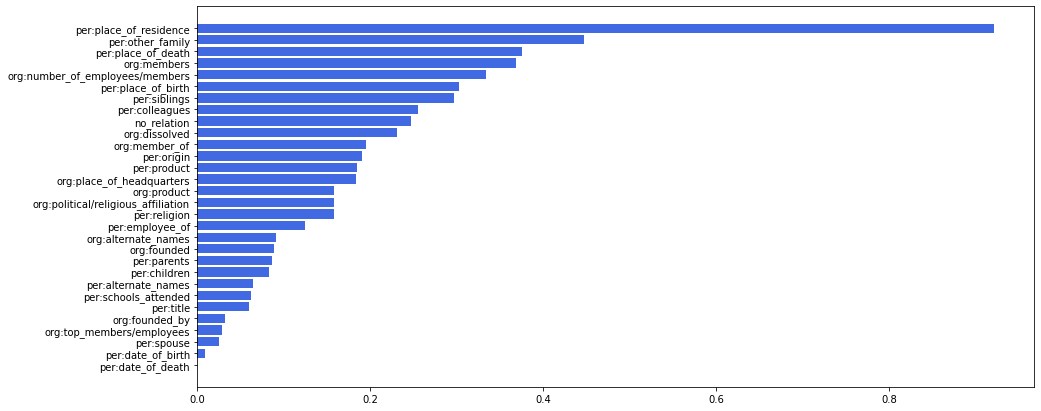

In [245]:
import matplotlib.pyplot as plt

# 오탐률 기준 정렬
temp_x = [] #라벨
temp_y = [] #퍼센트

for x, y in sorted(valid_percent.items() ,key = lambda x : x[1], reverse= True ): 
    print(f'{x:35} : {y : 0.5f} , label_data_count :{sum(valid_dict[x]) : 5}, [True,False] : {valid_dict[x]}')
    temp_x.append(x)
    temp_y.append(y)

#간단한 비율 확인 EDA
fig, axes = plt.subplots(1, 1, figsize=(15, 7))
axes.barh(temp_x[::-1], temp_y[::-1],color='royalblue')

plt.show()


In [246]:
#데이터 개수별 predict 결과 그룹화
pd.set_option('display.max_rows', None)
group = valid_df.groupby('label')['pred_answer'].value_counts()
group

label                                pred_answer                        
no_relation                          no_relation                            1434
                                     org:member_of                            77
                                     per:employee_of                          54
                                     per:title                                45
                                     org:place_of_headquarters                43
                                     org:top_members/employees                40
                                     per:colleagues                           31
                                     org:members                              29
                                     per:origin                               25
                                     org:product                              19
                                     org:founded                              16
                                    

['per:place_of_residence', 'per:other_family', 'per:place_of_death', 'org:members', 'org:number_of_employees/members', 'per:place_of_birth', 'per:siblings', 'per:colleagues', 'no_relation', 'org:dissolved']


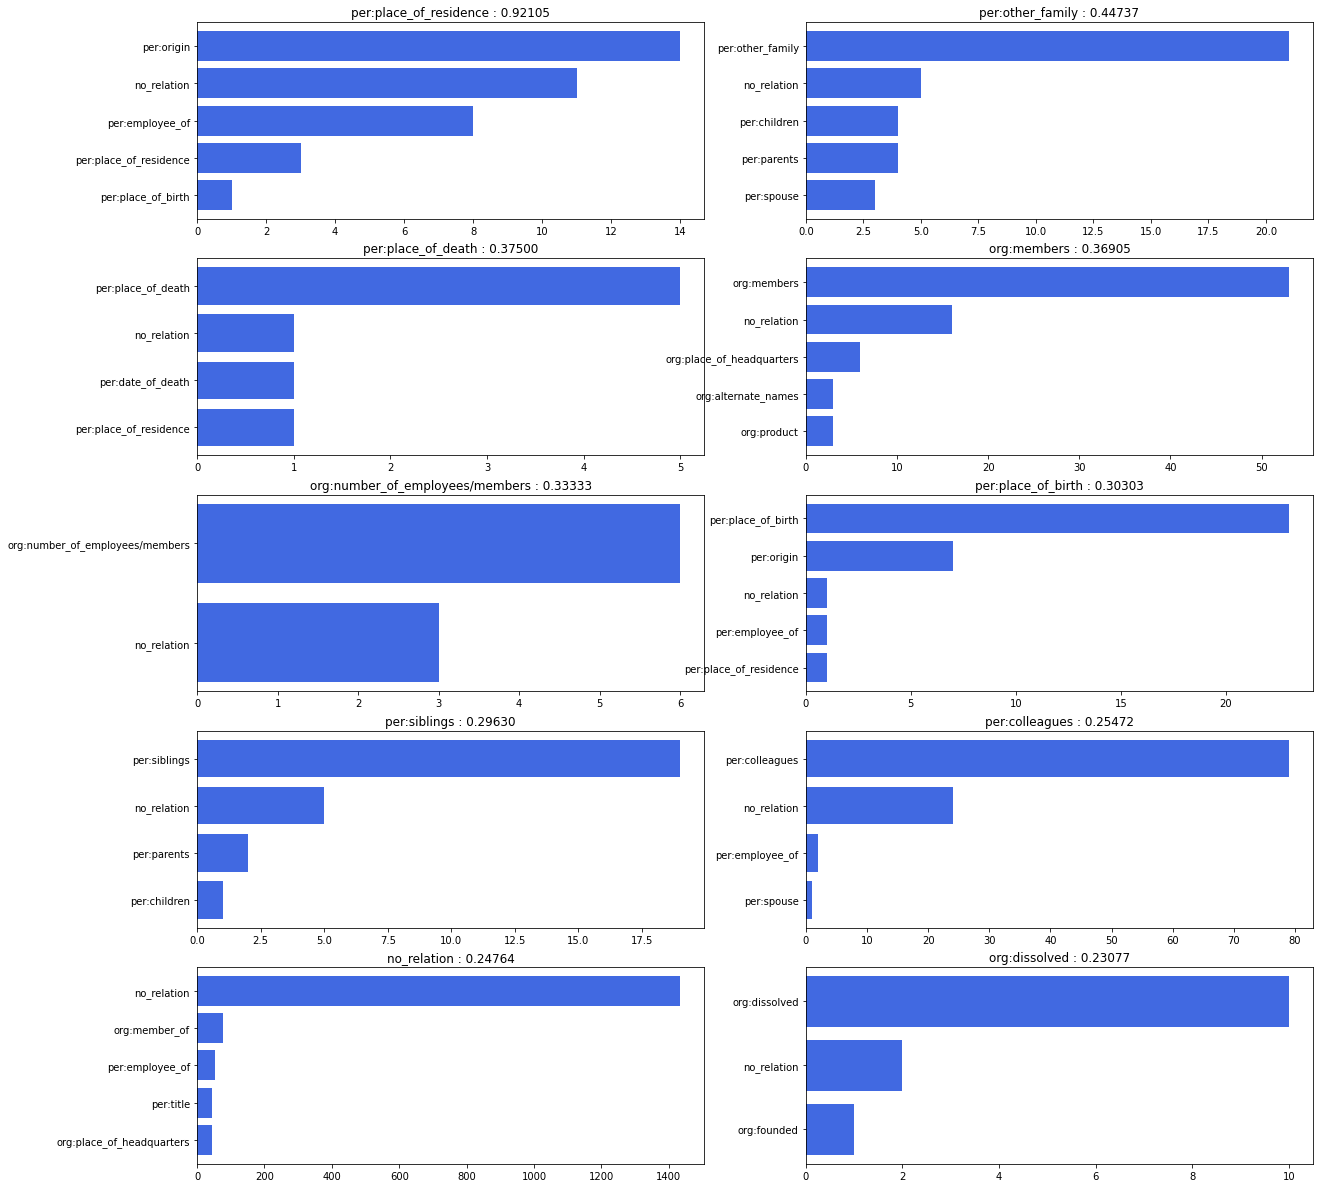

In [247]:
#정렬은 오탐률 기준입니다!

#top k 라벨별 EDA 
k = 10
top_k = temp_x[:k]
print(top_k)

#각 라벨별 predict 결과 top n 추출
n = 5

#x,y  조정
x = k//2 + k%2
y = 2

# 알맞게 fig size 조절
fig, axes = plt.subplots(x, y, figsize=(20, 21))

for i in range(k) :
    #print(i//y, i%y )
    axes[i//y][i%y].set_title(f'{top_k[i]} : {temp_y[i]:0.5f}')
    axes[i//y][i%y].barh(group[top_k[i]].index[:n][::-1], group[top_k[i]][:n][::-1], color='royalblue')
plt.show()

# Confusion Matrix로 표현

In [248]:
#데이터 내림 차순으로 정렬 및 라벨만 추출
descend_label_list = [x[0] for x in valid_item]
descend_label_list

['no_relation',
 'org:top_members/employees',
 'per:employee_of',
 'per:title',
 'org:member_of',
 'org:alternate_names',
 'per:origin',
 'org:place_of_headquarters',
 'per:date_of_birth',
 'per:alternate_names',
 'per:spouse',
 'per:colleagues',
 'per:parents',
 'org:founded',
 'org:members',
 'per:date_of_death',
 'org:product',
 'per:children',
 'per:place_of_residence',
 'per:other_family',
 'per:place_of_birth',
 'org:founded_by',
 'per:product',
 'per:siblings',
 'org:political/religious_affiliation',
 'per:religion',
 'per:schools_attended',
 'org:dissolved',
 'org:number_of_employees/members',
 'per:place_of_death']

In [249]:
#confusion matrix 계산을 위한 matrix_dict 
matrix_dict = [ [ 0 for i in range(30)] for i in range(30)]
for x, y in zip(valid_label, valid_predict) :
    matrix_dict[descend_label_list.index(x)][descend_label_list.index(y)] = matrix_dict[descend_label_list.index(x)][descend_label_list.index(y)] + 1


In [250]:
#출력
for idx, i  in enumerate(matrix_dict) :
    print(descend_label_list[idx] , i )

no_relation [1434, 40, 54, 45, 77, 12, 25, 43, 6, 9, 8, 31, 8, 16, 29, 4, 19, 5, 4, 8, 0, 1, 7, 0, 7, 8, 0, 5, 1, 0]
org:top_members/employees [14, 831, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0]
per:employee_of [43, 2, 625, 2, 2, 0, 30, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 4, 2, 0, 0, 0]
per:title [19, 0, 1, 395, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
org:member_of [31, 0, 5, 0, 300, 4, 0, 33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
org:alternate_names [16, 1, 0, 0, 2, 240, 1, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
per:origin [19, 0, 19, 0, 0, 0, 199, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
org:place_of_headquarters [24, 0, 0, 0, 10, 0, 2, 195, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
per:date_of_birth [2, 0, 0, 0, 0, 0, 0, 0, 224, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [251]:
#row별 개수 계산
total = np.sum(matrix_dict, axis= 1)

In [252]:
#normalize matrix
new_matrix = matrix_dict / total[:, None]

In [253]:
#내림차순으로 정렬된 matrix를 DataFrame으로 변환
new_df_cm = pd.DataFrame(new_matrix , index = descend_label_list[:] , columns = descend_label_list[:])
new_df_cm = new_df_cm.round(3)

[Text(0.5, 68.09375, 'predict'), Text(203.09375, 0.5, 'answer')]

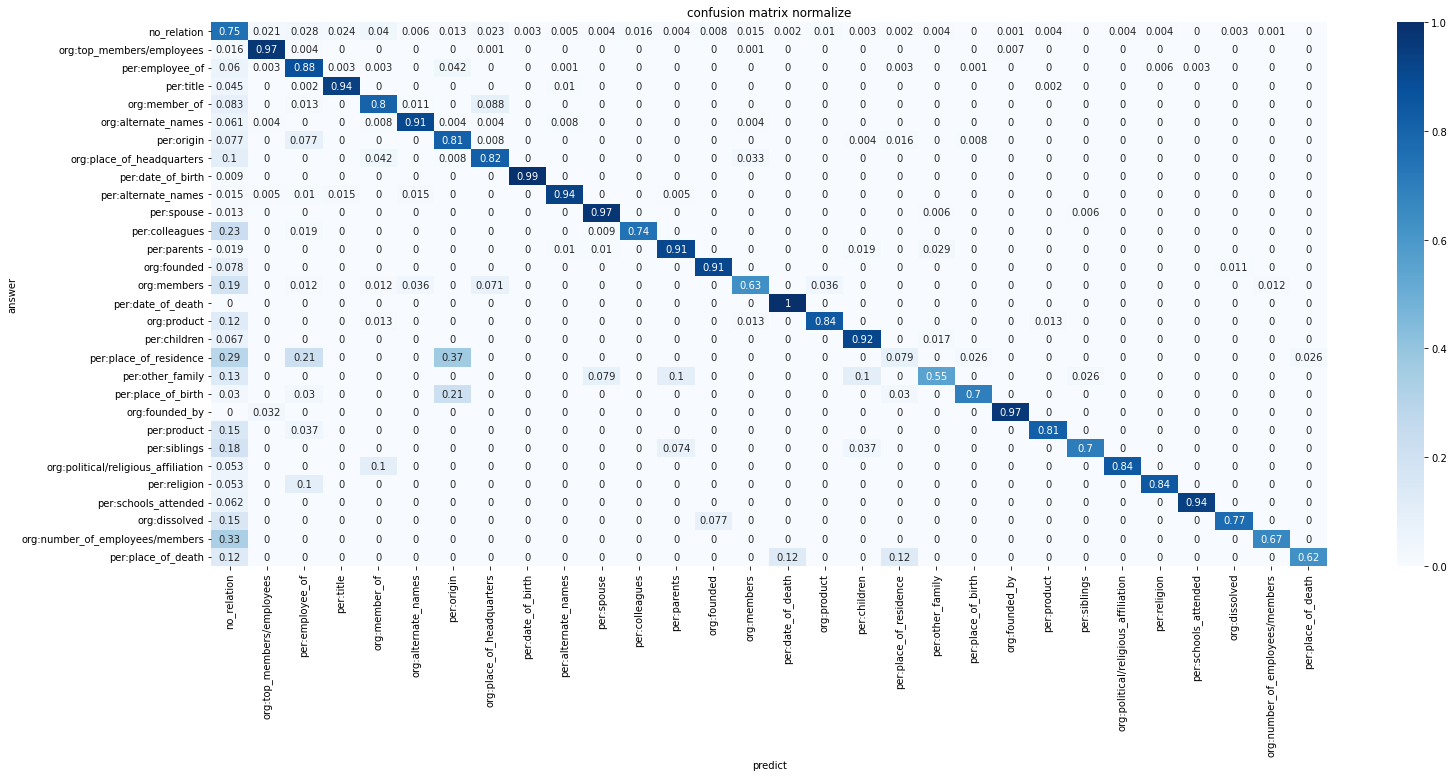

In [254]:
plt.figure(figsize=(25,10))
plt.title('confusion matrix normalize')
s =sns.heatmap(new_df_cm, annot = True, cmap = 'Blues')
s.set(xlabel='predict', ylabel='answer')